[brute] it=   0  residual=2.924e+00
[brute] it=  10  residual=7.096e-02
[brute] it=  20  residual=1.388e-02
[brute] it=  30  residual=3.008e-03
[dvqe ] it=   0  residual=2.924e+00
[dvqe ] it=  10  residual=6.885e-02
[dvqe ] it=  20  residual=1.320e-02
[dvqe ] it=  30  residual=3.003e-03


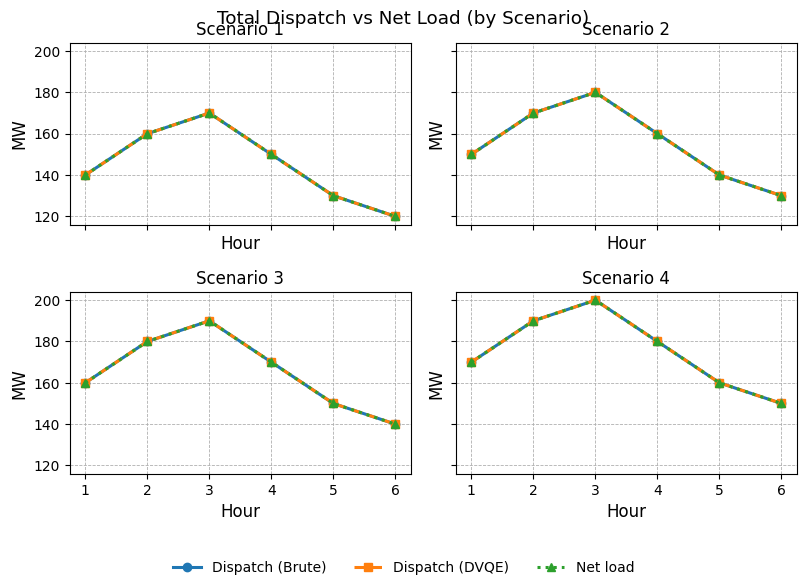

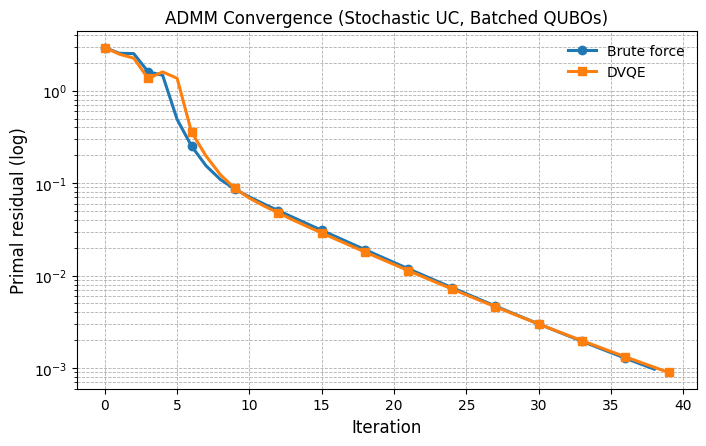

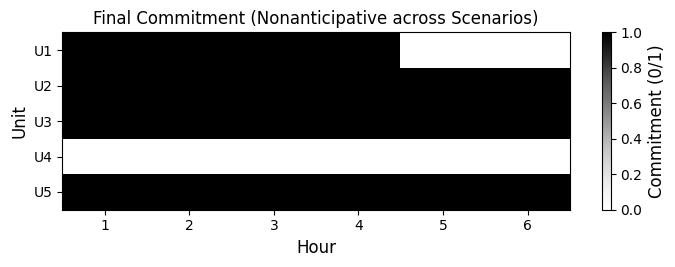


== Final commitment (shared across scenarios) ==
Unit  1: ON  ON  ON  ON  OFF OFF
Unit  2: ON  ON  ON  ON  ON  ON 
Unit  3: ON  ON  ON  ON  ON  ON 
Unit  4: OFF OFF OFF OFF OFF OFF
Unit  5: ON  ON  ON  ON  ON  ON 

== Residuals ==
Brute: final=9.741e-04, iters=39
DVQE : final=8.976e-04, iters=40

Commitment match between Brute and DVQE: False


In [8]:
# ============================================================
# Stochastic UC (5 units, T=6, S=4 scenarios)
# 3-Block ADMM with Block-2 solved as K batched micro-QUBOs:
#   (i) brute-force enumeration
#   (ii) DVQE (distributed VQE)
#
# - Nonanticipative binaries (y, u, v) across scenarios
# - Scenario-indexed continuous variables (p, rup, rdn)
# - Accept-if-better for each (i,t)
# - Publication-ready plots
# ============================================================

import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
from itertools import product

# If DVQE is available (raiselab), import it; otherwise this import will fail.
try:
    from raiselab import DVQE
    HAS_DVQE = True
except Exception:
    HAS_DVQE = False
    print("[WARN] DVQE not found. The 'dvqe' run will error unless you install raiselab.")

# -------------------------------
# Global plotting style (pub-ready)
# -------------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.2,
})

# -------------------------------
# Problem data (base deterministic)
# -------------------------------
N, T, S = 5, 6, 4  # 5 units, 6 periods, 4 scenarios

A = np.array([500, 600, 450, 400, 550], dtype=float)
B = np.array([20.0, 25.0, 18.0, 22.0, 21.0], dtype=float)
C = np.array([0.002, 0.0015, 0.0025, 0.002, 0.0018], dtype=float)
S_cost = np.array([200, 200, 250, 150, 180], dtype=float)
H_cost = np.array([0,   0,   0,   0,   0  ], dtype=float)

Pmin = np.array([10, 20, 15, 10, 20], dtype=float)
Pmax = np.array([60, 80, 70, 50, 85], dtype=float)

RU = np.array([30, 30, 25, 25, 30], dtype=float)
RD = np.array([30, 30, 25, 25, 30], dtype=float)
SU = np.array([40, 40, 35, 35, 40], dtype=float)
SD = np.array([40, 40, 35, 35, 40], dtype=float)

Umin = np.array([2, 2, 3, 2, 2], dtype=int)
Dmin = np.array([2, 2, 2, 2, 2], dtype=int)

L_base = np.array([150, 170, 180, 160, 140, 130], dtype=float)
R_up_base = np.array([10, 12, 12, 10, 8, 8], dtype=float)
R_dn_base = np.array([8, 8, 10, 10, 8, 6], dtype=float)
delta_tau = 1.0

# -------------------------------
# SCENARIOS: build 4 net-load scenarios and reserves
# (replace this block with your real scenario arrays if available)
# -------------------------------
# Additive offsets per scenario (MW); simple example
load_offsets = np.array([-10.0, 0.0, 10.0, 20.0])
Ps = np.array([0.25, 0.25, 0.25, 0.25])             # scenario probabilities

L_s = np.zeros((T, S))
R_up_s = np.zeros((T, S))
R_dn_s = np.zeros((T, S))
for s in range(S):
    L_s[:, s] = L_base + load_offsets[s]
    # Reserves scale mildly with load deviation (example); tweak as needed
    scale = 1.0 + (load_offsets[s] / max(1.0, np.mean(L_base))) * 0.5
    R_up_s[:, s] = np.clip(R_up_base * scale, 0.0, None)
    R_dn_s[:, s] = np.clip(R_dn_base * scale, 0.0, None)

# -------------------------------
# ADMM Hyperparameters
# -------------------------------
rho_y = rho_u = rho_v = 9.0e5
beta_y = beta_u = beta_v = 2.0e6
epsilon = 1e-3
max_iter = 4000

# Utility
ACCEPT_TOL   = 1e-12
Y_THRESHOLD  = 0.5
RAMP_TOL     = 1e-7

# Micro-QUBO penalties (scaled to rho_y)
gamma_c      = 0.20 * rho_y   # local (c) balance
gamma_ss     = 0.10 * rho_y   # discourage u & v both 1
gamma_u2y    = 0.05 * rho_y   # start implies on
gamma_v2ny   = 0.05 * rho_y   # shutdown implies off
gamma_y = gamma_u = gamma_v = 0.10 * rho_y  # anchors to Block-1

# -------------------------------
# Batching controls
# -------------------------------
K_BATCHES          = 3
HARD_EPS_ENERGY    = 1e-6
HARD_ETA           = 1e-9
HARD_WEIGHTS       = dict(w1=1.0, w2=1.0, w3=1.0, w4=1.0, w5=1.0)

# -------------------------------
# DVQE config
# -------------------------------
dvqe_mode = "distributed"
dvqe_depth = 2
dvqe_lr = 0.1
dvqe_max_iters = 100
qpu_qubit_config = [3, 3, 3, 3, 3]

# -------------------------------
# Helpers: brute-force QUBO & features
# -------------------------------
def solve_qubo_brute_force(Q, q_linear):
    Q = np.asarray(Q, dtype=float)
    q = np.asarray(q_linear, dtype=float).ravel()
    n = q.size
    if Q.shape != (n, n):
        raise ValueError(f"Q must be ({n},{n}), got {Q.shape}")
    Q = 0.5 * (Q + Q.T)
    best_z, best_cost = None, float("inf")
    for cand in product([0, 1], repeat=n):
        z = np.fromiter(cand, dtype=float, count=n)
        cost = z @ Q @ z + q @ z
        if cost < best_cost:
            best_cost = cost
            best_z = z.astype(int)
    return best_z, best_cost

def enumerate_energy(Q, c):
    Q = 0.5 * (Q + Q.T)
    out = []
    for cand in product([0, 1], repeat=3):
        z = np.array(cand, dtype=float)
        E = float(z @ Q @ z + c @ z)
        out.append((cand, E))
    return out

def hardness_score(Q, c, eps_energy_scale=1.0, weights=HARD_WEIGHTS):
    spec = enumerate_energy(Q, c)
    Es = sorted([E for _, E in spec])
    Emin = Es[0]
    Delta = Es[1] - Emin if len(Es) > 1 else float('inf')
    epsE = HARD_EPS_ENERGY * eps_energy_scale
    g_eps = sum(1 for E in Es if E <= Emin + epsE)

    Q12, Q23, Q13 = Q[0,1], Q[1,2], Q[0,2]
    prod_sign = np.sign(Q12 * Q23 * Q13)
    frustrated = 1 if prod_sign < 0 else 0

    coup = abs(Q12) + abs(Q23) + abs(Q13)
    field = abs(c[0]) + abs(c[1]) + abs(c[2]) + 1e-16
    r = coup / field

    coeffs = [abs(Q12), abs(Q23), abs(Q13), abs(c[0]), abs(c[1]), abs(c[2])]
    nz = [x for x in coeffs if x > 0]
    if len(nz) == 0:
        dr = 0.0
    else:
        M, m = max(nz), min(nz)
        dr = math.log10(M / m) if M > 0 and m > 0 else 0.0

    w1, w2, w3, w4, w5 = weights["w1"], weights["w2"], weights["w3"], weights["w4"], weights["w5"]
    score = (
        w1 * (1.0 / (Delta + HARD_ETA)) +
        w2 * ((g_eps - 1.0) / 7.0) +
        w3 * (1.0 * frustrated) +
        w4 * (r / (1.0 + r)) +
        w5 * (dr / 4.0)
    )
    return float(score)

def build_unit_batches_at_time_t(N, Q_list_t, c_list_t, k_batches=K_BATCHES):
    k_batches = max(1, min(k_batches, N))
    items = []
    for i in range(N):
        Q, c = Q_list_t[i], c_list_t[i]
        scale = (np.sum(np.abs(Q)) + np.sum(np.abs(c)) + 1.0)
        score = hardness_score(Q, c, eps_energy_scale=scale)
        items.append((i, score))
    items.sort(key=lambda x: x[1], reverse=True)
    batches = [[] for _ in range(k_batches)]
    batch_scores = [0.0 for _ in range(k_batches)]
    for i, score in items:
        b = int(np.argmin(batch_scores))
        batches[b].append(i)
        batch_scores[b] += score
    sizes = [len(b) for b in batches]
    return batches, batch_scores, sizes

# -------------------------------
# Micro-QUBO builder (3-bit per unit-time)
# -------------------------------
def micro_qubo_coeffs(qy, qu, qv, y_hat, u_hat, v_hat, y_ref,
                      gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                      gamma_y, gamma_u, gamma_v):
    Q = np.zeros((3,3), dtype=float)  # order: [y, u, v]
    c = np.array([qy, qu, qv], dtype=float)

    # anchors
    c[0] += gamma_y * (1 - 2 * y_hat)
    c[1] += gamma_u * (1 - 2 * u_hat) + gamma_u2y
    c[2] += gamma_v * (1 - 2 * v_hat)

    # (c) soft: (zy - zu + zv - y_ref)^2
    c[0] += gamma_c * (1 - 2 * y_ref)
    c[1] += gamma_c * (1 + 2 * y_ref)
    c[2] += gamma_c * (1 - 2 * y_ref)
    Q[0,1] += -2 * gamma_c; Q[1,0] = Q[0,1]
    Q[0,2] += +2 * gamma_c; Q[2,0] = Q[0,2]
    Q[1,2] += -2 * gamma_c; Q[2,1] = Q[1,2]

    # no u & v simultaneously
    Q[1,2] += gamma_ss; Q[2,1] = Q[1,2]

    # start -> on
    Q[0,1] += -gamma_u2y; Q[1,0] = Q[0,1]

    # shutdown -> off
    Q[0,2] += gamma_v2ny; Q[2,0] = Q[0,2]

    return Q, c

# -------------------------------
# Local AL term used by accept-if-better
# -------------------------------
def local_augL_alone(y_it, u_it, v_it, sy_it, su_it, sv_it,
                     lamy_it, lamu_it, lamv_it, zy, zu, zv,
                     rho_y, rho_u, rho_v):
    Ly = lamy_it * (y_it - zy + sy_it) + 0.5 * rho_y * (y_it - zy + sy_it)**2
    Lu = lamu_it * (u_it - zu + su_it) + 0.5 * rho_u * (u_it - zu + su_it)**2
    Lv = lamv_it * (v_it - zv + sv_it) + 0.5 * rho_v * (v_it - zv + sv_it)**2
    return float(Ly + Lu + Lv)

# -------------------------------
# One ADMM run (stochastic UC) with batched Block-2
# mode ∈ {"brute", "dvqe"}
# Returns dict with y,u,v, p_s[r][i,t,s], residuals, etc.
# -------------------------------
def run_stochastic_uc(mode="brute", verbose_every=10):
    p0 = np.ones(N)* 20
    y0 = (p0 > 0.0).astype(int)

    # Shared (nonanticipative) primals
    y = np.ones((N, T)) * 0.5
    u = np.zeros((N, T))
    v = np.zeros((N, T))

    # Scenario-indexed primals
    p_s  = np.tile(L_s[None, :, :], (N, 1, 1)) / max(N, 1)
    rup_s = np.zeros((N, T, S))
    rdn_s = np.zeros((N, T, S))

    # Block-2 binaries and slacks (nonanticipative)
    z_y = np.zeros((N, T), dtype=int)
    z_u = np.zeros((N, T), dtype=int)
    z_v = np.zeros((N, T), dtype=int)
    s_y = np.zeros((N, T))
    s_u = np.zeros((N, T))
    s_v = np.zeros((N, T))

    # Duals (nonanticipative)
    lam_y = np.zeros((N, T))
    lam_u = np.zeros((N, T))
    lam_v = np.zeros((N, T))

    residuals = []

    for it in range(max_iter):
        # ========= Block 1: Convex QP (shared y,u,v, scenario-wise p,r) =========
        yi  = cp.Variable((N, T))
        ui  = cp.Variable((N, T))
        vi  = cp.Variable((N, T))
        # scenario-indexed
        pi  = cp.Variable((N, T, S))
        rup = cp.Variable((N, T, S), nonneg=True)
        rdn = cp.Variable((N, T, S), nonneg=True)

        # Cost: first-stage (y,u,v) + expected second-stage (p)
        econ = (
            cp.sum(cp.multiply(A[:, None], yi)) +
            cp.sum(cp.multiply(S_cost[:, None], ui)) +
            cp.sum(cp.multiply(H_cost[:, None], vi))
        )
        # Expected production cost across scenarios
        prod_cost = 0
        for s in range(S):
            prod_cost += Ps[s] * (cp.sum(cp.multiply(B[:, None], pi[:, :, s])) +
                                  cp.sum(cp.multiply(C[:, None], cp.square(pi[:, :, s]))))
        pen_y = cp.sum(cp.multiply(lam_y, yi - z_y + s_y)) + (rho_y / 2) * cp.sum_squares(yi - z_y + s_y)
        pen_u = cp.sum(cp.multiply(lam_u, ui - z_u + s_u)) + (rho_u / 2) * cp.sum_squares(ui - z_u + s_u)
        pen_v = cp.sum(cp.multiply(lam_v, vi - z_v + s_v)) + (rho_v / 2) * cp.sum_squares(vi - z_v + s_v)

        objective = cp.Minimize(econ + prod_cost + pen_y + pen_u + pen_v)

        cons = []
        # Boxes for nonanticipative binaries (relaxed in Block 1)
        cons += [yi >= 0, yi <= 1, ui >= 0, ui <= 1, vi >= 0, vi <= 1]
        # Scenario constraints
        for s in range(S):
            cons += [pi[:, :, s] >= 0]
            # Power balance
            for t in range(T):
                cons += [cp.sum(pi[:, t, s]) == L_s[t, s]]
            # Capacity
            cons += [pi[:, :, s] >= cp.multiply(Pmin[:, None], yi)]
            cons += [pi[:, :, s] <= cp.multiply(Pmax[:, None], yi)]
            # Ramping (with t=1 vs p0/y0)
            for i in range(N):
                cons += [pi[i, 0, s] - p0[i] <= RU[i] * y0[i] + SU[i] * ui[i, 0]]
                cons += [p0[i] - pi[i, 0, s] <= RD[i] * yi[i, 0] + SD[i] * vi[i, 0]]
                for t in range(1, T):
                    cons += [pi[i, t, s] - pi[i, t-1, s] <= RU[i] * yi[i, t-1] + SU[i] * ui[i, t]]
                    cons += [pi[i, t-1, s] - pi[i, t, s] <= RD[i] * yi[i, t]   + SD[i] * vi[i, t]]
            # Reserves vs headroom/footroom
            cons += [rup[:, :, s] <= cp.multiply(Pmax[:, None], yi) - pi[:, :, s]]
            cons += [rdn[:, :, s] <= pi[:, :, s] - cp.multiply(Pmin[:, None], yi)]
            cons += [rup[:, :, s] <= RU[:, None] * delta_tau]
            cons += [rdn[:, :, s] <= RD[:, None] * delta_tau]
            # System reserve requirements
            for t in range(T):
                cons += [cp.sum(rup[:, t, s]) >= R_up_s[t, s]]
                cons += [cp.sum(rdn[:, t, s]) >= R_dn_s[t, s]]

        # Logic & min up/down (nonanticipative)
        cons += [yi[:, 0] - y0 == ui[:, 0] - vi[:, 0]]
        cons += [ui[:, 0] + vi[:, 0] <= 1]
        for t in range(1, T):
            cons += [yi[:, t] - yi[:, t-1] == ui[:, t] - vi[:, t]]
            cons += [ui[:, t] + vi[:, t] <= 1]
        for i in range(N):
            Ui, Di = int(Umin[i]), int(Dmin[i])
            for t in range(T):
                k_up = max(0, t - Ui + 1)
                k_dn = max(0, t - Di + 1)
                cons += [cp.sum(ui[i, k_up:t+1]) <= yi[i, t]]
                cons += [cp.sum(vi[i, k_dn:t+1]) <= 1 - yi[i, t]]

        # Warm start
        yi.value, ui.value, vi.value = y, u, v
        pi.value, rup.value, rdn.value = p_s, rup_s, rdn_s

        prob = cp.Problem(objective, cons)
        installed = set(cp.installed_solvers())
        status = "unknown"
        if "OSQP" in installed:
            prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8,
                       max_iter=800000, polish=True, warm_start=True, verbose=False)
            status = prob.status
        if status not in ("optimal", "optimal_inaccurate") and "SCS" in installed:
            prob.solve(solver=cp.SCS, eps=5e-8, max_iters=1_200_000,
                       warm_start=True, verbose=False)
            status = prob.status

        y   = yi.value
        u   = ui.value
        v   = vi.value
        p_s  = pi.value
        rup_s = rup.value
        rdn_s = rdn.value

        # ========= Block 2: K batched micro-QUBOs (nonanticipative) =========
        z_y_prev, z_u_prev, z_v_prev = z_y.copy(), z_u.copy(), z_v.copy()

        for t in range(T):
            # Base linear terms at this t (no scenario index)
            qy_vec = -(lam_y[:, t] + rho_y * (y[:, t] + s_y[:, t])) + 0.5 * rho_y
            qu_vec = -(lam_u[:, t] + rho_u * (u[:, t] + s_u[:, t])) + 0.5 * rho_u
            qv_vec = -(lam_v[:, t] + rho_v * (v[:, t] + s_v[:, t])) + 0.5 * rho_v

            # Build micro QUBOs for all units at time t
            Q_list_t, c_list_t = [], []
            for i in range(N):
                y_hat, u_hat, v_hat = y[i, t], u[i, t], v[i, t]
                y_ref = (z_y_prev[i, t-1] if t > 0 else y0[i])
                Q3, c3 = micro_qubo_coeffs(qy_vec[i], qu_vec[i], qv_vec[i],
                                           y_hat, u_hat, v_hat, y_ref,
                                           gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                                           gamma_y, gamma_u, gamma_v)
                Q_list_t.append(Q3); c_list_t.append(c3)

            # Partition into batches by hardness
            batches_t, _, _ = build_unit_batches_at_time_t(N, Q_list_t, c_list_t, k_batches=K_BATCHES)

            # Solve each batch and accept-if-better
            for units in batches_t:
                m = len(units)
                if m == 0: 
                    continue
                Qb = np.zeros((3*m, 3*m))
                cb = np.zeros(3*m)
                for k, i in enumerate(units):
                    Qb[3*k:3*k+3, 3*k:3*k+3] = Q_list_t[i]
                    cb[3*k:3*k+3] = c_list_t[i]

                if mode == "brute":
                    zb, _ = solve_qubo_brute_force(Qb, cb)
                elif mode == "dvqe":
                    if not HAS_DVQE:
                        raise RuntimeError("DVQE requested but 'raiselab' not installed.")
                    zb, _, _ = DVQE(mode=dvqe_mode, Q=Qb, q_linear=cb, init_type=2,
                                    depth=dvqe_depth, lr=dvqe_lr, max_iters=dvqe_max_iters,
                                    qpu_qubit_config=qpu_qubit_config, rel_tol=1e-6)
                else:
                    raise ValueError("mode must be 'brute' or 'dvqe'")
                zb = np.asarray(zb, dtype=int).ravel()

                # Unpack and accept-if-better
                for k, i in enumerate(units):
                    zy_new, zu_new, zv_new = map(int, zb[3*k:3*k+3])
                    old_al = local_augL_alone(y[i, t], u[i, t], v[i, t],
                                              s_y[i, t], s_u[i, t], s_v[i, t],
                                              lam_y[i, t], lam_u[i, t], lam_v[i, t],
                                              z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t],
                                              rho_y, rho_u, rho_v)
                    new_al = local_augL_alone(y[i, t], u[i, t], v[i, t],
                                              s_y[i, t], s_u[i, t], s_v[i, t],
                                              lam_y[i, t], lam_u[i, t], lam_v[i, t],
                                              zy_new, zu_new, zv_new,
                                              rho_y, rho_u, rho_v)
                    if new_al + ACCEPT_TOL <= old_al:
                        z_y[i, t], z_u[i, t], z_v[i, t] = zy_new, zu_new, zv_new
                    else:
                        z_y[i, t], z_u[i, t], z_v[i, t] = z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t]

        # ========= Block 3: Prox slacks + projection =========
        s_y = -(lam_y + rho_y * (y - z_y)) / (beta_y + rho_y)
        s_u = -(lam_u + rho_u * (u - z_u)) / (beta_u + rho_u)
        s_v = -(lam_v + rho_v * (v - z_v)) / (beta_v + rho_v)
        s_y = np.maximum(0.0, s_y)
        s_u = np.maximum(0.0, s_u)
        s_v = np.maximum(0.0, s_v)

        # ========= Dual updates =========
        lam_y = lam_y + 0.5 * rho_y * (y - z_y + s_y)
        lam_u = lam_u + 0.5 * rho_u * (u - z_u + s_u)
        lam_v = lam_v + 0.5 * rho_v * (v - z_v + s_v)

        # ========= Residual / stopping =========
        res = math.sqrt(
            np.linalg.norm((y - z_y + s_y).ravel())**2 +
            np.linalg.norm((u - z_u + s_u).ravel())**2 +
            np.linalg.norm((v - z_v + s_v).ravel())**2
        )
        residuals.append(res)

        if (it % verbose_every) == 0:
            print(f"[{mode:5s}] it={it:4d}  residual={res:.3e}")

        if res < epsilon:
            break

    # Thresholded commitment (shared across scenarios)
    y_bin = (y >= Y_THRESHOLD).astype(int)

    # Aggregate per-scenario totals (sum_i p_{i,t,s})
    total_p_ts = np.sum(p_s, axis=0)  # (T,S)

    return {
        "y": y, "u": u, "v": v,
        "y_bin": y_bin,
        "p_s": p_s, "rup_s": rup_s, "rdn_s": rdn_s,
        "total_p_ts": total_p_ts,
        "residuals": np.array(residuals, dtype=float),
        "status": "done"
    }

# -------------------------------
# RUNS: brute and dvqe
# -------------------------------
res_brute = run_stochastic_uc(mode="brute")
res_dvqe  = run_stochastic_uc(mode="dvqe")

# -------------------------------
# PLOTS
# -------------------------------

# (1) Total dispatch vs net load per scenario (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(8.2, 5.8), sharex=True, sharey=True)
axes = axes.ravel()
t_axis = np.arange(1, T+1)

for s in range(S):
    ax = axes[s]
    ax.plot(t_axis, res_brute["total_p_ts"][:, s], marker='o', label="Dispatch (Brute)")
    ax.plot(t_axis, res_dvqe["total_p_ts"][:, s], marker='s', linestyle='--', label="Dispatch (DVQE)")
    ax.plot(t_axis, L_s[:, s], marker='^', linestyle=':', label="Net load")
    ax.set_title(f"Scenario {s+1}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("MW")
    ax.grid(True, linestyle="--", linewidth=0.6)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)
fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.suptitle("Total Dispatch vs Net Load (by Scenario)", y=0.99)
plt.show()

# (2) ADMM primal residuals (log scale)
plt.figure(figsize=(7.2, 4.6))
plt.semilogy(res_brute["residuals"], label="Brute force", marker='o', markevery=max(1, len(res_brute["residuals"])//12))
plt.semilogy(res_dvqe["residuals"], label="DVQE", marker='s', markevery=max(1, len(res_dvqe["residuals"])//12))
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.xlabel("Iteration")
plt.ylabel("Primal residual (log)")
plt.title("ADMM Convergence (Stochastic UC, Batched QUBOs)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# (3) Commitment heatmap (shared across scenarios)
plt.figure(figsize=(7.2, 2.8))
y_heat = res_brute["y_bin"]  # brute and dvqe should match; pick one
plt.imshow(y_heat, aspect='auto', interpolation='nearest', cmap='Greys')
plt.colorbar(label="Commitment (0/1)")
plt.yticks(range(N), [f"U{i+1}" for i in range(N)])
plt.xticks(range(T), [f"{t}" for t in range(1, T+1)])
plt.xlabel("Hour")
plt.ylabel("Unit")
plt.title("Final Commitment (Nonanticipative across Scenarios)")
plt.tight_layout()
plt.show()

# -------------------------------
# Simple textual certification
# -------------------------------
print("\n== Final commitment (shared across scenarios) ==")
for i in range(N):
    row = " ".join("ON " if y_heat[i, t] else "OFF" for t in range(T))
    print(f"Unit {i+1:2d}: {row}")

print("\n== Residuals ==")
print(f"Brute: final={res_brute['residuals'][-1]:.3e}, iters={len(res_brute['residuals'])}")
print(f"DVQE : final={res_dvqe['residuals'][-1]:.3e}, iters={len(res_dvqe['residuals'])}")

# If desired, you can assert/compare equality of commitments:
same_commit = np.array_equal(res_brute["y_bin"], res_dvqe["y_bin"])
print(f"\nCommitment match between Brute and DVQE: {same_commit}")


In [9]:
def print_dispatch(label, res):
    p_s = res["p_s"]  # (N,T,S)
    print(f"\n===== {label}: Dispatch per unit / hour / scenario =====")
    for s in range(S):
        print(f"\n================  Scenario {s+1}  ================")
        hdr = "Unit\\Hour | " + " ".join([f"{t:>7d}" for t in range(1, T+1)])
        print(hdr)
        print("-" * len(hdr))
        for i in range(N):
            row = " ".join(f"{p_s[i, t, s]:7.2f}" for t in range(T))
            print(f"U{i+1:02d}       | {row}")
        totals = [float(np.sum(p_s[:, t, s])) for t in range(T)]
        totals_str = " ".join(f"{x:7.2f}" for x in totals)
        loads_str  = " ".join(f"{L_s[t, s]:7.2f}" for t in range(T))
        print("-" * len(hdr))
        print(f"Σ Dispatch | {totals_str}")
        print(f"Net Load   | {loads_str}")

# Print both
print_dispatch("Brute force", res_brute)
print_dispatch("DVQE",        res_dvqe)



===== Brute force: Dispatch per unit / hour / scenario =====

================  Scenario 1  ================
Unit\Hour |       1       2       3       4       5       6
-----------------------------------------------------------
U01       |   50.00   50.02   60.00   40.00    0.00    0.00
U02       |   20.00   20.00   20.00   20.00   20.00   20.00
U03       |   45.00   69.99   69.99   69.99   69.99   69.99
U04       |    0.00   -0.00    0.00    0.00    0.00   -0.00
U05       |   25.00   20.00   20.02   20.02   40.02   30.02
-----------------------------------------------------------
Σ Dispatch |  140.00  160.00  170.00  150.00  130.00  120.00
Net Load   |  140.00  160.00  170.00  150.00  130.00  120.00

================  Scenario 2  ================
Unit\Hour |       1       2       3       4       5       6
-----------------------------------------------------------
U01       |   50.00   60.00   60.00   40.00   -0.00    0.00
U02       |   20.00   20.00   20.00   20.00   20.00   20.00


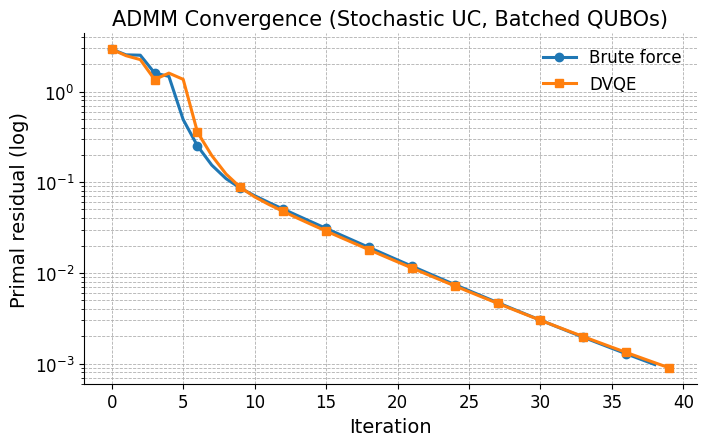

In [10]:
# (2) ADMM primal residuals (log scale, paper-ready)
plt.figure(figsize=(7.2, 4.6))

plt.semilogy(
    res_brute["residuals"], 
    label="Brute force", 
    marker='o', 
    markevery=max(1, len(res_brute["residuals"])//12)
)
plt.semilogy(
    res_dvqe["residuals"], 
    label="DVQE", 
    marker='s', 
    markevery=max(1, len(res_dvqe["residuals"])//12)
)

# === Clean look ===
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# === Fonts & grid ===
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Primal residual (log)", fontsize=14)
plt.title("ADMM Convergence (Stochastic UC, Batched QUBOs)", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)

plt.tight_layout()

# === Save as JPG ===
plt.savefig("admm_convergence.jpg", dpi=600, bbox_inches="tight")
plt.show()
